# Chapter 10: Neural Networks（ニューラルネットワーク）

このノートブックは [Nature of Code](https://natureofcode.com/neural-networks/) の第10章をJuliaで実装したものです。

## 概要

ニューラルネットワークは、生物の神経系を模倣した計算モデルです。
入力から出力への非線形なマッピングを学習することができます。

In [1]:
using LinearAlgebra
using Plots
using Random

## 10.1 パーセプトロン（Perceptron）

最も単純なニューラルネットワークの構成単位。
複数の入力を受け取り、重み付け和を計算し、活性化関数を通して出力を生成します。

### パーセプトロンの3ステップ

1. **重み付け**: 各入力に重みを掛ける
2. **加算**: 重み付けされた入力を合計
3. **活性化**: 合計を活性化関数に通す

In [2]:
mutable struct Perceptron
    weights::Vector{Float64}
    learningRate::Float64
end

function Perceptron(n::Int; learningRate=0.01)
    weights = [rand() * 2 - 1 for _ in 1:n]  # -1 ~ 1
    Perceptron(weights, learningRate)
end

# 活性化関数（ステップ関数）
function activate(sum::Float64)
    return sum >= 0 ? 1 : -1
end

# 順伝播
function feedforward(p::Perceptron, inputs::Vector{Float64})
    # 重み付け和を計算
    sum = dot(inputs, p.weights)
    # 活性化
    return activate(sum)
end

# 訓練（1サンプル）
function train!(p::Perceptron, inputs::Vector{Float64}, target::Int)
    guess = feedforward(p, inputs)
    error = target - guess
    
    # 重みを更新
    # new_weight = weight + error * input * learning_rate
    for i in eachindex(p.weights)
        p.weights[i] += error * inputs[i] * p.learningRate
    end
    
    return error
end

train! (generic function with 1 method)

In [3]:
# 例：線形分類問題
# 目標：y = 0.5x + 1 の上下を分類

function f(x)
    return 0.5 * x + 1
end

# 訓練データを生成
function generateTrainingData(n::Int)
    data = []
    for _ in 1:n
        x = rand() * 200 - 100  # -100 ~ 100
        y = rand() * 200 - 100
        
        # 線の上なら1、下なら-1
        label = y > f(x) ? 1 : -1
        
        # バイアス項を追加（常に1）
        push!(data, ([x, y, 1.0], label))
    end
    return data
end

# 訓練
p = Perceptron(3, learningRate=0.001)
trainingData = generateTrainingData(2000)

errors = Float64[]
for (inputs, target) in trainingData
    err = train!(p, inputs, target)
end

println("学習後の重み: $(p.weights)")

学習後の重み: [-0.3087100088962611, 0.6189539683852252, -0.6519843326723447]


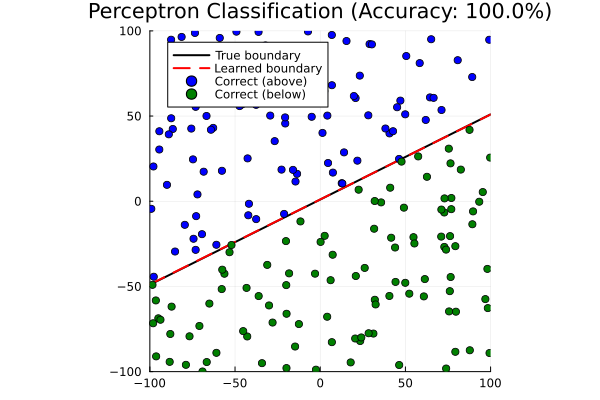

In [4]:
# 結果を可視化
function visualize_perceptron(p::Perceptron)
    # テストデータ
    testData = generateTrainingData(200)
    
    # 正解と予測を分類
    correct_above = Tuple{Float64, Float64}[]
    correct_below = Tuple{Float64, Float64}[]
    wrong = Tuple{Float64, Float64}[]
    
    for (inputs, target) in testData
        guess = feedforward(p, inputs)
        if guess == target
            if target == 1
                push!(correct_above, (inputs[1], inputs[2]))
            else
                push!(correct_below, (inputs[1], inputs[2]))
            end
        else
            push!(wrong, (inputs[1], inputs[2]))
        end
    end
    
    # プロット
    plt = plot(xlims=(-100, 100), ylims=(-100, 100), aspect_ratio=:equal)
    
    # 真の境界線
    xs = -100:100
    plot!(plt, xs, f.(xs), label="True boundary", linewidth=2, color=:black)
    
    # 学習した境界線 (w1*x + w2*y + w3 = 0 → y = -(w1*x + w3)/w2)
    learned_y(x) = -(p.weights[1] * x + p.weights[3]) / p.weights[2]
    plot!(plt, xs, learned_y.(xs), label="Learned boundary", 
          linewidth=2, color=:red, linestyle=:dash)
    
    # データ点
    if !isempty(correct_above)
        scatter!(plt, [c[1] for c in correct_above], [c[2] for c in correct_above],
                 color=:blue, markersize=4, label="Correct (above)")
    end
    if !isempty(correct_below)
        scatter!(plt, [c[1] for c in correct_below], [c[2] for c in correct_below],
                 color=:green, markersize=4, label="Correct (below)")
    end
    if !isempty(wrong)
        scatter!(plt, [w[1] for w in wrong], [w[2] for w in wrong],
                 color=:red, markersize=6, markershape=:x, label="Wrong")
    end
    
    accuracy = (length(correct_above) + length(correct_below)) / length(testData) * 100
    title!("Perceptron Classification (Accuracy: $(round(accuracy, digits=1))%)")
    
    return plt
end

visualize_perceptron(p)

## 10.2 多層パーセプトロン（MLP）

単一のパーセプトロンは線形分離可能な問題しか解けません（XOR問題は解けない）。
隠れ層を追加することで、非線形な問題も解けるようになります。

### ネットワーク構造

```
入力層 → 隠れ層 → 出力層
```

In [5]:
# 活性化関数（シグモイド）
sigmoid(x) = 1 / (1 + exp(-x))
sigmoid_derivative(x) = x * (1 - x)

# 多層ニューラルネットワーク
mutable struct NeuralNetwork
    inputNodes::Int
    hiddenNodes::Int
    outputNodes::Int
    weightsIH::Matrix{Float64}  # 入力→隠れ層
    weightsHO::Matrix{Float64}  # 隠れ層→出力
    biasH::Vector{Float64}
    biasO::Vector{Float64}
    learningRate::Float64
end

function NeuralNetwork(inputNodes::Int, hiddenNodes::Int, outputNodes::Int; 
                       learningRate=0.1)
    # 重みをランダム初期化（Xavier初期化）
    weightsIH = randn(hiddenNodes, inputNodes) * sqrt(2.0 / inputNodes)
    weightsHO = randn(outputNodes, hiddenNodes) * sqrt(2.0 / hiddenNodes)
    biasH = zeros(hiddenNodes)
    biasO = zeros(outputNodes)
    
    NeuralNetwork(inputNodes, hiddenNodes, outputNodes, 
                  weightsIH, weightsHO, biasH, biasO, learningRate)
end

# 順伝播
function feedforward(nn::NeuralNetwork, inputs::Vector{Float64})
    # 隠れ層
    hidden = sigmoid.(nn.weightsIH * inputs .+ nn.biasH)
    
    # 出力層
    output = sigmoid.(nn.weightsHO * hidden .+ nn.biasO)
    
    return output
end

feedforward (generic function with 2 methods)

## 10.3 バックプロパゲーション（誤差逆伝播法）

多層ネットワークを訓練するアルゴリズム。
出力層の誤差を、各層の重みの寄与度に応じて逆方向に伝播させます。

### アルゴリズム

1. 順伝播で出力を計算
2. 出力誤差を計算
3. 誤差を逆伝播して各層の重みを更新

In [6]:
function train!(nn::NeuralNetwork, inputs::Vector{Float64}, targets::Vector{Float64})
    # === 順伝播 ===
    # 隠れ層
    hiddenInputs = nn.weightsIH * inputs .+ nn.biasH
    hiddenOutputs = sigmoid.(hiddenInputs)
    
    # 出力層
    outputInputs = nn.weightsHO * hiddenOutputs .+ nn.biasO
    outputs = sigmoid.(outputInputs)
    
    # === 誤差計算 ===
    outputErrors = targets .- outputs
    
    # 隠れ層の誤差（出力層の誤差を逆伝播）
    hiddenErrors = nn.weightsHO' * outputErrors
    
    # === 重み更新 ===
    # 出力層の勾配
    outputGradients = outputErrors .* sigmoid_derivative.(outputs) * nn.learningRate
    
    # 隠れ層→出力層の重み更新
    nn.weightsHO .+= outputGradients * hiddenOutputs'
    nn.biasO .+= outputGradients
    
    # 隠れ層の勾配
    hiddenGradients = hiddenErrors .* sigmoid_derivative.(hiddenOutputs) * nn.learningRate
    
    # 入力層→隠れ層の重み更新
    nn.weightsIH .+= hiddenGradients * inputs'
    nn.biasH .+= hiddenGradients
    
    return sum(outputErrors.^2)  # 二乗誤差を返す
end

train! (generic function with 2 methods)

In [7]:
# XOR問題を学習
function train_xor()
    nn = NeuralNetwork(2, 4, 1, learningRate=0.5)
    
    # XORの訓練データ
    trainingData = [
        ([0.0, 0.0], [0.0]),
        ([0.0, 1.0], [1.0]),
        ([1.0, 0.0], [1.0]),
        ([1.0, 1.0], [0.0])
    ]
    
    errors = Float64[]
    
    for epoch in 1:10000
        totalError = 0.0
        for (inputs, targets) in trainingData
            err = train!(nn, inputs, targets)
            totalError += err
        end
        push!(errors, totalError / 4)
        
        if epoch % 2000 == 0
            println("Epoch $epoch: Average Error = $(round(totalError/4, digits=6))")
        end
    end
    
    # テスト
    println("\nTest Results:")
    for (inputs, targets) in trainingData
        output = feedforward(nn, inputs)
        println("$(inputs) -> $(round(output[1], digits=3)) (expected: $(targets[1]))")
    end
    
    return nn, errors
end

nn_xor, xor_errors = train_xor()

Epoch 2000: Average Error = 0.000932


Epoch 4000: Average Error = 0.000429
Epoch 6000: Average Error = 0.000279
Epoch 8000: Average Error = 0.000207
Epoch 10000: Average Error = 0.000164

Test Results:
[0.0, 0.0] -> 0.001 (expected: 0.0)
[0.0, 1.0] -> 0.988 (expected: 1.0)
[1.0, 0.0] -> 0.986 (expected: 1.0)
[1.0, 1.0] -> 0.017 (expected: 0.0)


(NeuralNetwork(2, 4, 1, [8.378070226217693 8.206134460759078; 9.089249269608164 -11.900337186144217; 9.472843820322009 -6.305807782717145; 11.036031334108518 -8.264052144918459], [3.9145787149992453 8.352333491008025 -3.097962460728537 -5.468669987893969], [-2.3966308421121285, -3.5136796485678183, 2.060273786913672, 3.1967556527232817], [0.5750250774654242], 0.5), [0.28391647787598895, 0.27842685859945954, 0.2755443953308883, 0.27406673581741203, 0.27329456521168294, 0.2728591195776413, 0.2725763972918234, 0.27235799640111535, 0.27216293011474296, 0.2719730522449352  …  0.00016433966754123122, 0.00016432278804353706, 0.00016430591202448928, 0.00016428903948301476, 0.0001642721704180353, 0.0001642553048284757, 0.00016423844271326149, 0.00016422158407131604, 0.00016420472890156952, 0.00016418787720294363])

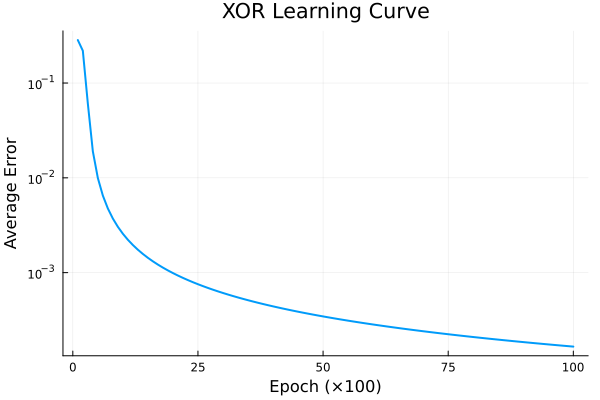

In [8]:
# 学習曲線をプロット
plot(xor_errors[1:100:end], xlabel="Epoch (×100)", ylabel="Average Error",
     title="XOR Learning Curve", legend=false, linewidth=2, yscale=:log10)

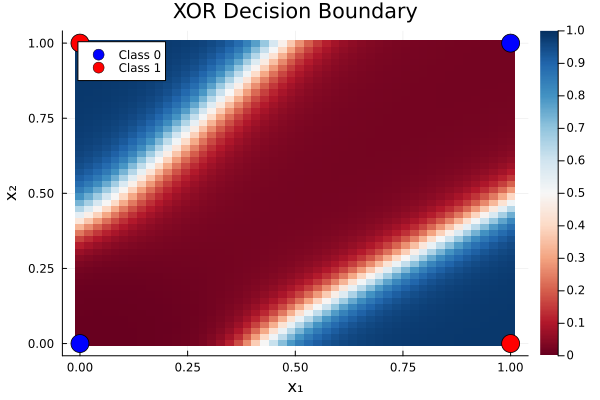

In [9]:
# XORの決定境界を可視化
function visualize_xor(nn::NeuralNetwork)
    xs = range(0, 1, length=50)
    ys = range(0, 1, length=50)
    
    Z = zeros(length(xs), length(ys))
    
    for (i, x) in enumerate(xs)
        for (j, y) in enumerate(ys)
            Z[j, i] = feedforward(nn, [x, y])[1]
        end
    end
    
    heatmap(xs, ys, Z, c=:RdBu, clims=(0, 1),
            xlabel="x₁", ylabel="x₂", title="XOR Decision Boundary")
    
    # データ点を追加
    scatter!([0, 1], [0, 1], color=:blue, markersize=10, label="Class 0")
    scatter!([0, 1], [1, 0], color=:red, markersize=10, label="Class 1")
end

visualize_xor(nn_xor)

## 10.4 ニューラルネットワークの構成要素

### 重み（Weights）
ニューロン間の接続強度。学習によって調整される。

### バイアス（Bias）
各ニューロンのしきい値を調整。常に1の入力に掛けられる重み。

### 活性化関数（Activation Function）
非線形性を導入する関数。

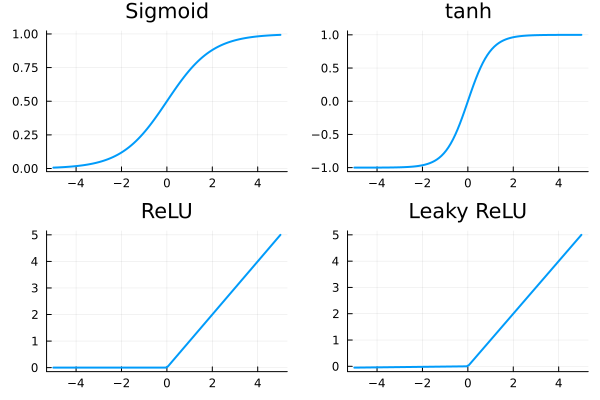

In [10]:
# 様々な活性化関数

# シグモイド
sigmoid(x) = 1 / (1 + exp(-x))

# tanh
tanh_act(x) = tanh(x)

# ReLU
relu(x) = max(0, x)

# Leaky ReLU
leaky_relu(x) = x > 0 ? x : 0.01 * x

# 可視化
x = range(-5, 5, length=100)

p1 = plot(x, sigmoid.(x), title="Sigmoid", legend=false, linewidth=2)
p2 = plot(x, tanh_act.(x), title="tanh", legend=false, linewidth=2)
p3 = plot(x, relu.(x), title="ReLU", legend=false, linewidth=2)
p4 = plot(x, leaky_relu.(x), title="Leaky ReLU", legend=false, linewidth=2)

plot(p1, p2, p3, p4, layout=(2, 2), size=(600, 400))

## 10.5 Neuroevolution（神経進化）

遺伝的アルゴリズムでニューラルネットワークの重みを進化させます。
バックプロパゲーションの代わりに、自然選択で学習します。

In [11]:
# ニューラルネットワークのDNA（重みの配列）
mutable struct NeuroBrain
    nn::NeuralNetwork
    fitness::Float64
end

function NeuroBrain(inputNodes::Int, hiddenNodes::Int, outputNodes::Int)
    nn = NeuralNetwork(inputNodes, hiddenNodes, outputNodes)
    NeuroBrain(nn, 0.0)
end

# DNAを配列として取得
function getDNA(brain::NeuroBrain)
    return vcat(vec(brain.nn.weightsIH), vec(brain.nn.weightsHO), 
                brain.nn.biasH, brain.nn.biasO)
end

# 配列からDNAを設定
function setDNA!(brain::NeuroBrain, dna::Vector{Float64})
    idx = 1
    
    # weightsIH
    for i in eachindex(brain.nn.weightsIH)
        brain.nn.weightsIH[i] = dna[idx]
        idx += 1
    end
    
    # weightsHO
    for i in eachindex(brain.nn.weightsHO)
        brain.nn.weightsHO[i] = dna[idx]
        idx += 1
    end
    
    # biasH
    for i in eachindex(brain.nn.biasH)
        brain.nn.biasH[i] = dna[idx]
        idx += 1
    end
    
    # biasO
    for i in eachindex(brain.nn.biasO)
        brain.nn.biasO[i] = dna[idx]
        idx += 1
    end
end

# 交叉
function crossover(a::NeuroBrain, b::NeuroBrain)
    child = NeuroBrain(a.nn.inputNodes, a.nn.hiddenNodes, a.nn.outputNodes)
    
    dnaA = getDNA(a)
    dnaB = getDNA(b)
    childDNA = similar(dnaA)
    
    midpoint = rand(1:length(dnaA))
    for i in eachindex(childDNA)
        if i < midpoint
            childDNA[i] = dnaA[i]
        else
            childDNA[i] = dnaB[i]
        end
    end
    
    setDNA!(child, childDNA)
    return child
end

# 突然変異
function mutate!(brain::NeuroBrain, mutationRate::Float64)
    dna = getDNA(brain)
    
    for i in eachindex(dna)
        if rand() < mutationRate
            dna[i] += randn() * 0.5
        end
    end
    
    setDNA!(brain, dna)
end

mutate! (generic function with 1 method)

In [12]:
# 神経進化でXOR問題を解く
function neuroevolution_xor(;popSize=100, generations=200, mutationRate=0.1)
    # XORの訓練データ
    testCases = [
        ([0.0, 0.0], 0.0),
        ([0.0, 1.0], 1.0),
        ([1.0, 0.0], 1.0),
        ([1.0, 1.0], 0.0)
    ]
    
    # 初期集団
    population = [NeuroBrain(2, 4, 1) for _ in 1:popSize]
    
    bestFitness = Float64[]
    
    for gen in 1:generations
        # 適応度計算
        for brain in population
            totalError = 0.0
            for (inputs, target) in testCases
                output = feedforward(brain.nn, inputs)[1]
                totalError += (target - output)^2
            end
            brain.fitness = 1.0 / (1.0 + totalError)
        end
        
        # 最良を記録
        best = population[argmax([b.fitness for b in population])]
        push!(bestFitness, best.fitness)
        
        if gen % 50 == 0
            println("Gen $gen: Best fitness = $(round(best.fitness, digits=4))")
        end
        
        # 選択と交叉
        matingPool = NeuroBrain[]
        maxFit = maximum(b.fitness for b in population)
        
        for brain in population
            n = Int(floor(brain.fitness / maxFit * 100))
            for _ in 1:max(1, n)
                push!(matingPool, brain)
            end
        end
        
        # 次世代
        newPopulation = NeuroBrain[]
        
        # エリート選択（最良を保存）
        push!(newPopulation, best)
        
        for _ in 2:popSize
            parentA = rand(matingPool)
            parentB = rand(matingPool)
            child = crossover(parentA, parentB)
            mutate!(child, mutationRate)
            push!(newPopulation, child)
        end
        
        population = newPopulation
    end
    
    # 最終結果
    best = population[argmax([b.fitness for b in population])]
    
    println("\nFinal Results:")
    for (inputs, target) in testCases
        output = feedforward(best.nn, inputs)[1]
        println("$(inputs) -> $(round(output, digits=3)) (expected: $target)")
    end
    
    return best, bestFitness
end

best_brain, neuro_fitness = neuroevolution_xor()

Gen 50: Best fitness = 0.5672


Gen 100: Best fitness = 0.6477
Gen 150: Best fitness = 0.7955
Gen 200: Best fitness = 0.9203

Final Results:
[0.0, 0.0] -> 0.126 (expected: 0.0)
[0.0, 1.0] -> 0.86 (expected: 1.0)
[1.0, 0.0] -> 0.914 (expected: 1.0)
[1.0, 1.0] -> 0.209 (expected: 0.0)


(NeuroBrain(NeuralNetwork(2, 4, 1, [2.7801581704566294 2.8816686220196503; 0.9502660208484003 -1.6031581908504875; -6.024505216894097 -8.677500742822886; -1.8893232549069356 -2.688014048353582], [-5.088138009673754 1.6404148077786882 -6.037120189411782 2.020720603527967], [-4.213298873709929, 2.2442823883961247, 1.8755593090131635, 5.761465842948094], [-0.12349777188846522], 0.1), 0.9203185184114278), [0.5069007070822963, 0.5069007070822963, 0.5087567223267797, 0.5088429335208579, 0.511544388345915, 0.5123508091193819, 0.5123508091193819, 0.5123508091193819, 0.5123508091193819, 0.5123508091193819  …  0.8862183813293064, 0.8862183813293064, 0.8879434507256512, 0.8879434507256512, 0.9087425743243822, 0.9087425743243822, 0.9087425743243822, 0.9087425743243822, 0.9203185184114278, 0.9203185184114278])

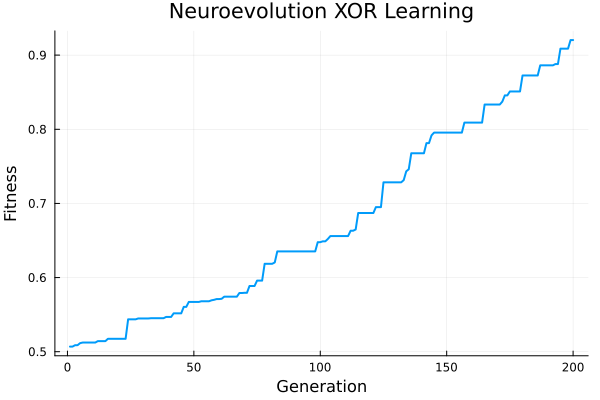

In [13]:
# 学習曲線を比較
plot(neuro_fitness, xlabel="Generation", ylabel="Fitness",
     title="Neuroevolution XOR Learning", legend=false, linewidth=2)

## 10.6 自律エージェントの脳として使用

ニューラルネットワークを自律エージェントの意思決定に使用できます。

In [14]:
# ニューラルネットワークで制御されるエージェント
mutable struct SmartAgent
    position::Vector{Float64}
    velocity::Vector{Float64}
    brain::NeuralNetwork
    health::Float64
end

function SmartAgent(x::Float64, y::Float64)
    # 入力: [食べ物までの角度, 距離, 現在の速度]
    # 出力: [左に曲がる量, 右に曲がる量]
    brain = NeuralNetwork(4, 8, 2, learningRate=0.0)
    SmartAgent([x, y], [rand()*2-1, rand()*2-1], brain, 100.0)
end

function think!(agent::SmartAgent, food::Vector{Float64})
    # 入力を計算
    toFood = food - agent.position
    dist = sqrt(sum(toFood.^2))
    angle = atan(toFood[2], toFood[1])
    heading = atan(agent.velocity[2], agent.velocity[1])
    angleDiff = angle - heading
    
    inputs = [angleDiff / π, dist / 200, agent.velocity[1], agent.velocity[2]]
    
    # ニューラルネットワークで行動を決定
    output = feedforward(agent.brain, inputs)
    
    # 出力を行動に変換（回転）
    turnAmount = (output[1] - output[2]) * 0.1
    
    # 速度を回転
    speed = sqrt(sum(agent.velocity.^2))
    if speed > 0
        heading += turnAmount
        agent.velocity = [cos(heading), sin(heading)] * min(speed, 3.0)
    end
    
    # 位置を更新
    agent.position .+= agent.velocity
    agent.health -= 0.5
end

think! (generic function with 1 method)

## 10.7 パターン認識の例

より実践的な例として、簡単なパターン認識タスクを実装します。

In [15]:
# 円と四角形の分類
function create_pattern_data(n::Int)
    data = []
    
    for _ in 1:n
        # 特徴: [縦横比, 角の数（近似）, 曲率（近似）]
        if rand() < 0.5
            # 円のような特徴
            aspectRatio = 0.9 + rand() * 0.2  # ~1.0
            corners = rand() * 0.2  # 少ない
            curvature = 0.8 + rand() * 0.2  # 高い
            label = [1.0, 0.0]  # 円
        else
            # 四角形のような特徴
            aspectRatio = 0.5 + rand() * 1.0
            corners = 0.7 + rand() * 0.3  # 多い（角がある）
            curvature = rand() * 0.3  # 低い
            label = [0.0, 1.0]  # 四角形
        end
        
        push!(data, ([aspectRatio, corners, curvature], label))
    end
    
    return data
end

# 訓練
nn_pattern = NeuralNetwork(3, 6, 2, learningRate=0.3)
trainingData = create_pattern_data(1000)

errors = Float64[]
for epoch in 1:100
    shuffle!(trainingData)
    totalError = 0.0
    
    for (inputs, targets) in trainingData
        err = train!(nn_pattern, inputs, targets)
        totalError += err
    end
    
    push!(errors, totalError / length(trainingData))
end

# テスト
testData = create_pattern_data(100)
correct = 0

for (inputs, targets) in testData
    output = feedforward(nn_pattern, inputs)
    predicted = argmax(output)
    actual = argmax(targets)
    if predicted == actual
        correct += 1
    end
end

println("Accuracy: $(correct / length(testData) * 100)%")

Accuracy: 100.0%


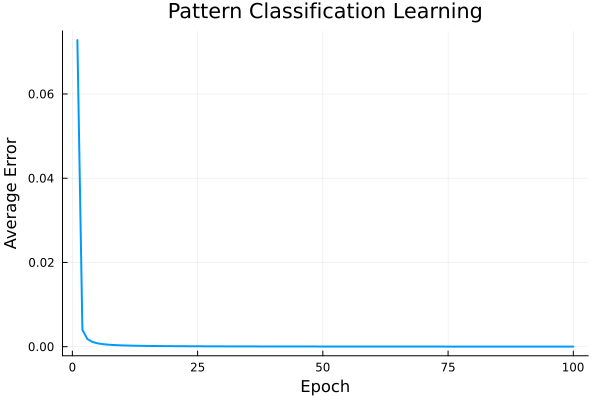

In [16]:
plot(errors, xlabel="Epoch", ylabel="Average Error",
     title="Pattern Classification Learning", legend=false, linewidth=2)

## まとめ

### ニューラルネットワークの構成要素

| 要素 | 説明 |
|------|------|
| ニューロン | 入力を処理して出力を生成する基本単位 |
| 重み | 接続の強さ（学習で調整） |
| バイアス | しきい値の調整 |
| 活性化関数 | 非線形性を導入 |
| 層 | ニューロンのグループ |

### 学習アルゴリズム

1. **パーセプトロン学習則**: 単層用、線形分離問題のみ
2. **バックプロパゲーション**: 多層用、勾配降下法
3. **神経進化**: 遺伝的アルゴリズムで重みを最適化

### 重要な概念

- **順伝播**: 入力から出力への計算
- **誤差逆伝播**: 誤差を逆方向に伝播して重みを更新
- **学習率**: 重み更新の大きさを制御
- **過学習**: 訓練データに過度に適応すること

### 応用分野

- 画像認識
- 自然言語処理
- ゲームAI
- 自律エージェントの制御
- 予測・分類タスク